In [1]:
!nvidia-smi

Wed Mar 24 14:14:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

import tensorflow_probability as tfp
tfd = tfp.distributions

In [3]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [4]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
y_train = pd.get_dummies(y_train.flatten()).values.astype(np.float32)

x_test = x_test.astype("float32") / 255.0
y_test = pd.get_dummies(y_test.flatten()).values.astype(np.float32)

In [5]:
print("Shape of x_train: ",x_train.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of x_test: ",x_test.shape)
print("Shape of y_test: ",y_test.shape)

Shape of x_train:  (50000, 32, 32, 3)
Shape of y_train:  (50000, 10)
Shape of x_test:  (10000, 32, 32, 3)
Shape of y_test:  (10000, 10)


In [6]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 5
IMAGE_SIZE = 32

In [7]:
simple_aug = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ]
)

In [8]:
# Put aside a few samples to create our validation set
val_samples = 500
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

train_ds_two = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

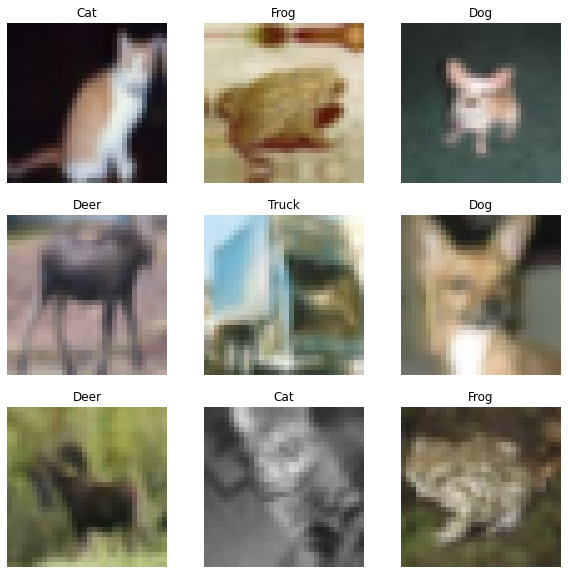

In [9]:
sample_images, sample_labels = next(iter(train_ds_one))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label.numpy().tolist())])
    plt.imshow(image.numpy().squeeze())
    plt.axis("off")

In [10]:
@tf.function
def get_bbox(l):
  cut_rat = tf.math.sqrt(1.-l)

  cut_w = IMAGE_SIZE*cut_rat #rw
  cut_w = tf.cast(cut_w, tf.int32)
  
  cut_h = IMAGE_SIZE*cut_rat #rh
  cut_h = tf.cast(cut_h, tf.int32)
  
  cx = tf.random.uniform((1,), minval=0, maxval=IMAGE_SIZE, dtype=tf.int32) #rx
  cy = tf.random.uniform((1,), minval=0, maxval=IMAGE_SIZE, dtype=tf.int32) #ry
  
  bbx1 = tf.clip_by_value(cx[0] - cut_w // 2, 0, IMAGE_SIZE)
  bby1 = tf.clip_by_value(cy[0] - cut_h // 2, 0, IMAGE_SIZE)
  bbx2 = tf.clip_by_value(cx[0] + cut_w // 2, 0, IMAGE_SIZE)
  bby2 = tf.clip_by_value(cy[0] + cut_h // 2, 0, IMAGE_SIZE)
  
  target_h = bby2-bby1
  if target_h ==0:
    target_h+=1

  target_w = bbx2-bbx1
  if target_w ==0:
    target_w+=1

  return bbx1, bby1, target_h, target_w

@tf.function
def cutmix(a, b):
  
  (image1, label1), (image2, label2) = a, b

  alpha = [1.]
  beta = [1.]
  
  ## Get sample from beta distribution
  dist = tfd.Beta(alpha, beta)
  ## Lambda
  l = dist.sample(1)[0][0]

  ## Get bbox ofsets and heights anda widths
  bbx1, bby1, target_h, target_w = get_bbox(l)

  ## Get patch from image2
  crop2 = tf.image.crop_to_bounding_box(image2, bby1, bbx1, target_h, target_w)
  ## Pad the patch with same offset
  image2 = tf.image.pad_to_bounding_box(crop2, bby1, bbx1, IMAGE_SIZE, IMAGE_SIZE)
  ## Get patch from image1
  crop1 = tf.image.crop_to_bounding_box(image1, bby1, bbx1, target_h, target_w)
  ## Pad the patch with same offset
  img1 = tf.image.pad_to_bounding_box(crop1, bby1, bbx1, IMAGE_SIZE, IMAGE_SIZE)

  ## Subtract the patch from image1 so that patch from image2 can be put on instead
  image1 = image1-img1
  ## Add modified image1 and image2 to get cutmix image
  image = image1+image2

  ## Adjust lambda according to pixel ration
  l = 1 - (target_w * target_h) / (IMAGE_SIZE * IMAGE_SIZE)
  l = tf.cast(l, tf.float32)

  ## Combine labels
  label = l*label1+(1-l)*label2

  return image, label

In [11]:
train_ds_cmu = (
    train_ds
    .map(cutmix, num_parallel_calls=AUTO)
)

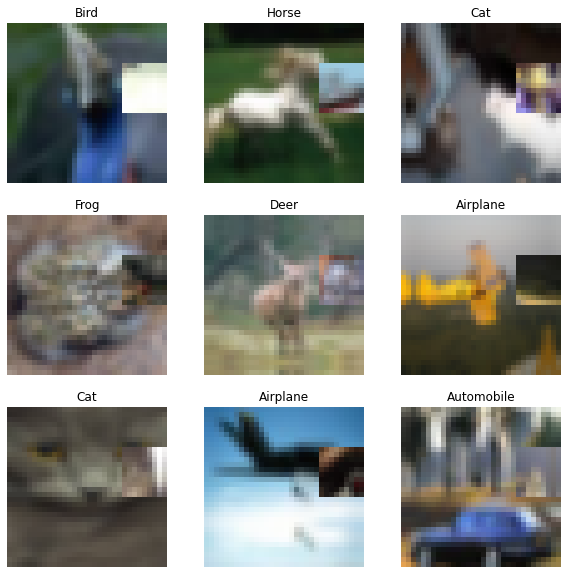

In [12]:
sample_images, sample_labels = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label.numpy().tolist())])
    plt.imshow(image.numpy().squeeze())
    plt.axis("off")

In [13]:
def training_model():
    model = tf.keras.Sequential(
        [
            layers.Conv2D(32, (5, 5), activation="relu", input_shape=(32, 32, 3)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.GlobalAvgPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model

In [14]:
initial_model = training_model()
initial_model.save_weights("initial_weights.h5")

In [15]:
model = training_model()
model.load_weights("initial_weights.h5")

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(train_ds_cmu, validation_data=val_ds, epochs=EPOCHS)

test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/5
774/774 [==============================] - 51s 27ms/step - loss: 2.1704 - accuracy: 0.1915 - val_loss: 1.7168 - val_accuracy: 0.3780
Epoch 2/5
774/774 [==============================] - 21s 27ms/step - loss: 2.0240 - accuracy: 0.2791 - val_loss: 1.6163 - val_accuracy: 0.4220
Epoch 3/5
774/774 [==============================] - 20s 26ms/step - loss: 1.9670 - accuracy: 0.3119 - val_loss: 1.5773 - val_accuracy: 0.4600
Epoch 4/5
774/774 [==============================] - 21s 27ms/step - loss: 1.9285 - accuracy: 0.3440 - val_loss: 1.4956 - val_accuracy: 0.4860
Epoch 5/5
157/157 [==============================] - 1s 3ms/step - loss: 1.4736 - accuracy: 0.4793
Test accuracy: 47.93%


In [16]:
model = training_model()
model.load_weights("initial_weights.h5")

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Notice that we are NOT using the mixed up dataset here
model.fit(train_ds_one, validation_data=val_ds, epochs=EPOCHS)

test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/5
774/774 [==============================] - 10s 12ms/step - loss: 2.0178 - accuracy: 0.2343 - val_loss: 1.6982 - val_accuracy: 0.3560
Epoch 2/5
774/774 [==============================] - 9s 12ms/step - loss: 1.6723 - accuracy: 0.3770 - val_loss: 1.4399 - val_accuracy: 0.4460
Epoch 3/5
774/774 [==============================] - 9s 12ms/step - loss: 1.5371 - accuracy: 0.4373 - val_loss: 1.3461 - val_accuracy: 0.4940
Epoch 4/5
774/774 [==============================] - 9s 12ms/step - loss: 1.4468 - accuracy: 0.4774 - val_loss: 1.3822 - val_accuracy: 0.5180
Epoch 5/5
157/157 [==============================] - 1s 3ms/step - loss: 1.2955 - accuracy: 0.5367
Test accuracy: 53.67%
